# Bias in permutations

We'll use different test statistics to detect unequal frequency of permutations in R.
We compute the statistic over many permutations, then compare the distribution to the asymptotic distribution of the statistic.
We have to use asymptotic approximations because we cannot calibrate distributions by permutation -- the permutation distribution is exactly what we are looking at!

# Spearman correlation

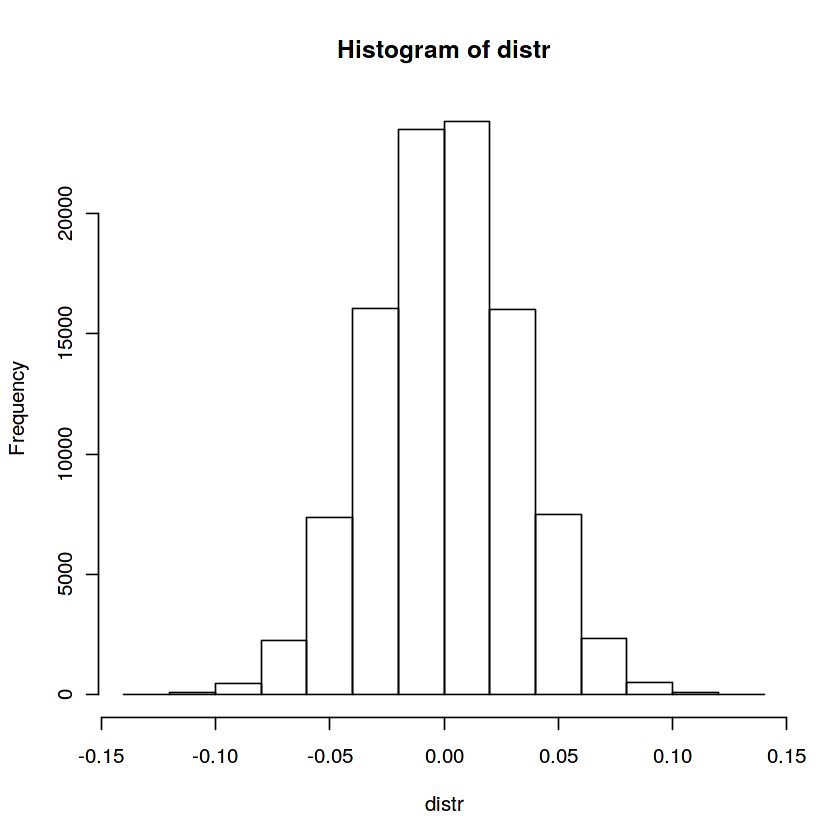

In [3]:
set.seed(1234567890)
n <- 1000
vec <- 1:n
reps <- 10^5

# Under the null, there should be no relationship between a vector and its permutations

distr <- replicate(reps, cor(vec, sample(vec), method = "spearman"))
hist(distr)

According to Wikipedia, the following transformation of the correlation $r$ is approximately standard normal:

$$z=\sqrt{\frac{n-3}{1.06}}F(r)$$
where $F(r)=\frac{1}{2}\ln \frac{1+r}{1-r}$ is the Fisher transformation.

Warning message in ks.test(z, y = "pnorm", alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  z
D = 0.0096285, p-value = 1.772e-08
alternative hypothesis: two-sided


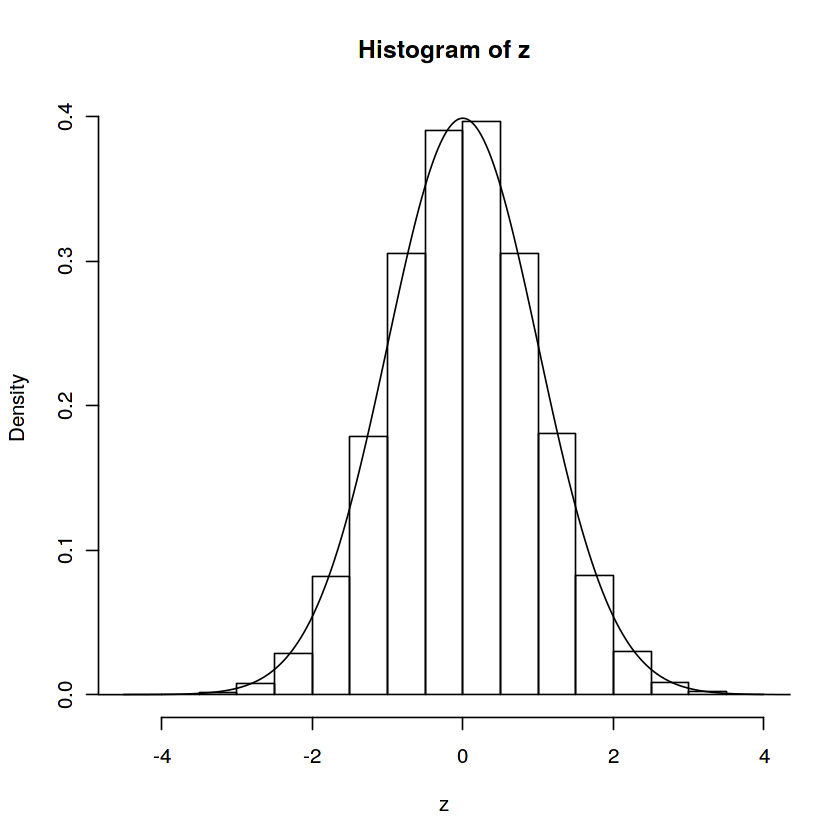

In [4]:
# transformation 1
z <- sqrt((n-3)/1.06)*0.5*log((1+distr)/(1-distr))
hist(z, freq = FALSE)
lines(seq(-5, 5, by = 0.01), sapply(seq(-5, 5, by = 0.01), function(x) dnorm(x)))
ks.test(z, y = "pnorm", alternative = "two.sided")

Also according to Wikipedia, one can test the Spearman correlation using the $t$-distribution on $n-2$ degrees of freedom, using the transformation

$$t=r\sqrt{\frac{n-2}{1-r^{2}}}.$$

Warning message in ks.test(t, y = function(x) pt(x, df = n - 2)):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  t
D = 0.0031894, p-value = 0.2609
alternative hypothesis: two-sided


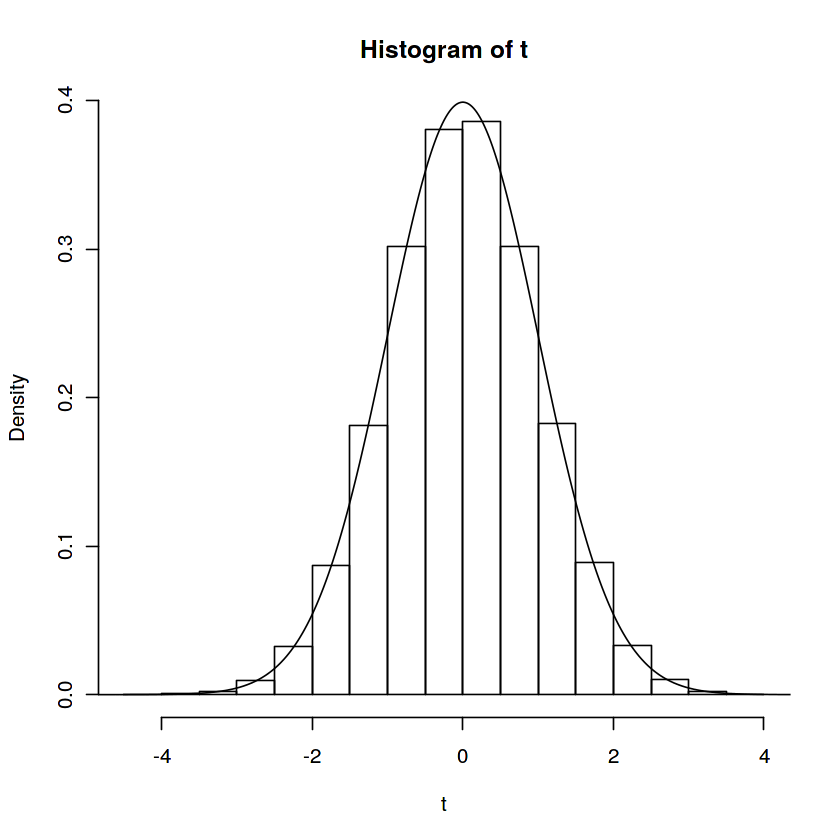

In [5]:
# transformation 2
t <- distr*sqrt((n-2)/(1-distr^2))
hist(t, freq = FALSE)
lines(seq(-5, 5, by = 0.01), sapply(seq(-5, 5, by = 0.01), function(x) dt(x, df = n-2)))
ks.test(t, y = function(x) pt(x, df=n-2))

# Runs test

We count the number of runs in each permutation, where a run is defined as a sequence of values which are all above or all below the median of the list.

We derived the distribution of the number of runs. Let $N_+$ and $N_-$ denote the number of items greater than or equal to the median and the number of items less than the median, respectively, with $N_+ + N_- = N$.

$N_+$ is distributed as binomial with $N$ trials and probability $1/2$. Conditionally on $N_+$, $N_-$ is determined, and the distribution of the number of runs is approximately normal with mean

$$\mu_{N_+} = \frac{2N_{+}N_{-}}{N}+1$$
and variance
$$\sigma^2_{N_+} = \frac{2N_{+}N_{-}(2N_{+}N_{-}-N)}{N^{2}(N-1)}=\frac{(\mu_{N_+} -1)(\mu_{N_+} -2)}{N-1}.$$

In [6]:

measureRuns <- function(samp){
  gtMedian <- samp >= median(samp)
  numRuns <- sum(diff(gtMedian) != 0) + 1
  return(numRuns)
}

count_nplus <- function(samp){
  N <- length(samp)
  runs <- samp >= median(samp)
  counts <- c("below" = sum(runs == 0) ,
              "above"   = sum(runs == 1))
  return(counts[1])
}

mu_nplus <- function(nplus, N){
  return( (2*nplus*(N-nplus))/N + 1 )
}

sigma2_nplus <- function(nplus, N){
  mu <- mu_nplus(nplus, N)
  return( ((mu-1)*(mu-2))/(N-1) )
}


runs_cdf_nplus <- function(R, nplus, N){
  # Evaluate the probability that # runs <= R in a sequence of length N,
  # conditional on nplus = the number of + in the sequence
  return(pnorm((R + - mu_nplus(nplus, N))/sqrt(sigma2_nplus(nplus, N))))
}


runs_cdf <- function(R, N){
  # Evaluate the probability that # runs <= R in a sequence of length N,
  # unconditional on the number of + and - in the sequence
  summation <- sapply(0:N, function(nplus) choose(N, nplus)*runs_cdf_nplus(R, nplus, N))
  return(sum(summation)*2^(-N))
}

inv_sample_runs <- function(N, size = 1){
  # Draw random samples from the distribution of number of runs, unconditional on N_+
  nplus <- rbinom(size, N, prob = 1/2)
  val <- rnorm(size, mean = sapply(nplus, function(x) mu_nplus(x, N)), 
      sd = sqrt(sapply(nplus, function(x) sigma2_nplus(x, N))))
  return(val)
}

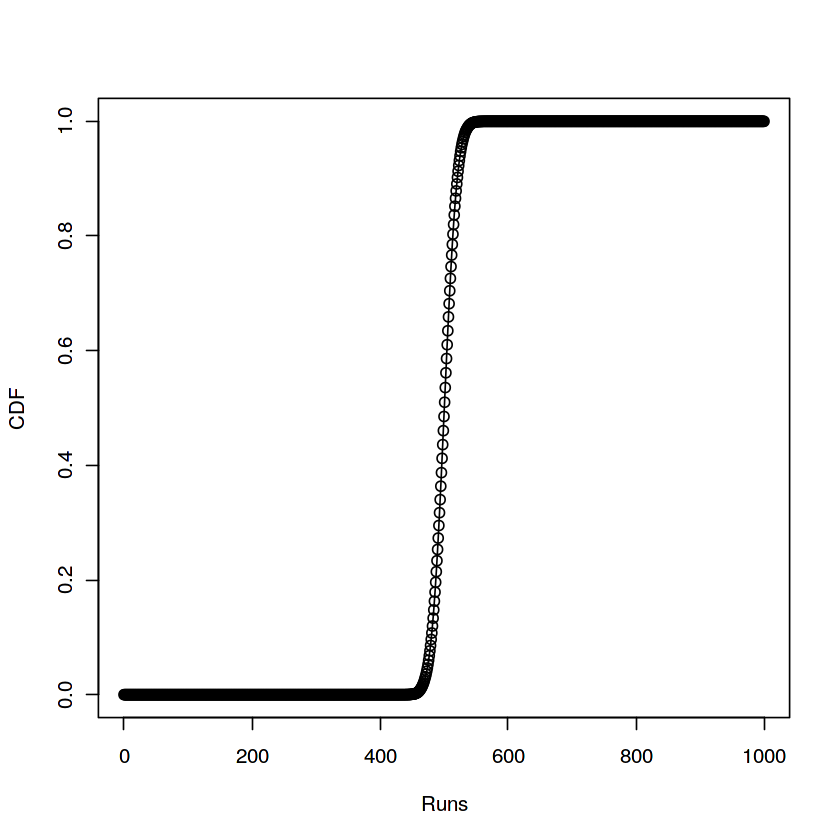

In [10]:
res <- replicate(reps, measureRuns(sample(vec)))
plot(0:n, sapply(0:n, function(r) mean(res <= r)),
    xlab = "Runs",
    ylab = "CDF")
lines(0:n, sapply(0:n, function(r) runs_cdf(r, n)))

In [11]:
sample_from_cdf <- inv_sample_runs(n, size = reps)
ks.test(res, sample_from_cdf)

Warning message in ks.test(res, sample_from_cdf):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  res and sample_from_cdf
D = 0.03154, p-value < 2.2e-16
alternative hypothesis: two-sided
